In [3]:
import sys
sys.path.append("../..")

In [14]:
import pandas as pd
import deepmatcher as dm
import torch

In [2]:
def duplicateColumns (df,ignore_columns =['id','label']):
    for col in list(df):
        if col not in ignore_columns:
            df[col+"1"] = df[col]

In [18]:
train = pd.read_csv('../../Structured/itunes-amazon/merged_train.csv')
valid = pd.read_csv('../../Structured/itunes-amazon/merged_valid.csv')
test = pd.read_csv('../../Structured/itunes-amazon/merged_test.csv')
duplicateColumns(train)
duplicateColumns(valid)
duplicateColumns(test)

In [5]:
train.to_csv('temp/train_dupcolumns.csv',index=False)
valid.to_csv('temp/valid_dupcolumns.csv',index=False)
test.to_csv('temp/test_dupcolumns.csv',index=False)

In [8]:
train,valid,test = dm.data.process('temp/',train='train_dupcolumns.csv',validation='valid_dupcolumns.csv',test='test_dupcolumns.csv',
                                  cache='exp14.pth',left_prefix='ltable_',right_prefix='rtable_')

In [10]:
hybrid_model = dm.MatchingModel(attr_summarizer='hybrid')
hybrid_model.run_train(train,valid,best_save_path='../../models/itunesamazon_dupcolumns_hybrid.pth',epochs=30,
                      pos_neg_ratio=5,batch_size=16)

* Number of trainable parameters: 35333818
===>  TRAIN Epoch 1
Finished Epoch 1 || Run Time:   13.6 | Load Time:    2.1 || F1:  43.06 | Prec:  27.64 | Rec:  97.44 || Ex/s:  20.38

===>  EVAL Epoch 1
Finished Epoch 1 || Run Time:    1.3 | Load Time:    0.6 || F1:  57.50 | Prec:  43.40 | Rec:  85.19 || Ex/s:  55.06

* Best F1: 57.50000000000001
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 2
Finished Epoch 2 || Run Time:   14.6 | Load Time:    2.2 || F1:  65.40 | Prec:  51.88 | Rec:  88.46 || Ex/s:  19.06

===>  EVAL Epoch 2
Finished Epoch 2 || Run Time:    1.3 | Load Time:    0.6 || F1:  71.64 | Prec:  60.00 | Rec:  88.89 || Ex/s:  54.84

* Best F1: 71.64179104477611
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 3
Finished Epoch 3 || Run Time:   14.6 | Load Time:    2.3 || F1:  81.91 | Prec:  70.00 | Rec:  98.72 || Ex/s:  19.01

===>  EVAL Epoch 3
Finished Epoch 3 || Run Time:    1.3 | Load Time:    0.6 || F1:  75.36 | Prec:  61.90 | Rec:  96.

Finished Epoch 27 || Run Time:    1.6 | Load Time:    0.7 || F1:  81.25 | Prec:  70.27 | Rec:  96.30 || Ex/s:  48.77

---------------------

===>  TRAIN Epoch 28
Finished Epoch 28 || Run Time:   14.4 | Load Time:    2.2 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  19.25

===>  EVAL Epoch 28
Finished Epoch 28 || Run Time:    1.6 | Load Time:    0.7 || F1:  81.25 | Prec:  70.27 | Rec:  96.30 || Ex/s:  48.31

---------------------

===>  TRAIN Epoch 29
Finished Epoch 29 || Run Time:   14.1 | Load Time:    2.2 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  19.60

===>  EVAL Epoch 29
Finished Epoch 29 || Run Time:    1.6 | Load Time:    0.7 || F1:  81.25 | Prec:  70.27 | Rec:  96.30 || Ex/s:  48.59

---------------------

===>  TRAIN Epoch 30
Finished Epoch 30 || Run Time:   14.5 | Load Time:    2.2 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  19.13

===>  EVAL Epoch 30
Finished Epoch 30 || Run Time:    1.6 | Load Time:    0.7 || F1:  81.25 | Prec:  70.27 | Rec:  96.30

82.53968253968253

In [11]:
hybrid_model.run_eval(test)

===>  EVAL Epoch 6
Finished Epoch 6 || Run Time:    0.8 | Load Time:    0.6 || F1:  84.75 | Prec:  78.12 | Rec:  92.59 || Ex/s:  74.31



84.7457627118644

In [19]:
test_neg = test[test['label']==0].copy()
test_neg.to_csv('temp/test_negatives_dupcolumns.csv',index=False)
test_pos = test[test['label']==1].copy()
test_pos.to_csv('temp/test_positives_dupcolumns.csv',index=False)

In [5]:
from utilities_functions.intermediate_layer_extraction import return_layer_input_output,return_layer_input
import torch
attributes = ['Song_Name','Artist_Name','Album_Name','Genre','Price','CopyRight','Time','Released']
attribute_duplicates = attributes.copy()
for attr in attributes:
    attribute_duplicates.append(attr+"1")

In [22]:
testneg_classifier_inputs,testneg_ids = return_layer_input('temp','test_negatives_dupcolumns',32,hybrid_model,
                                                                        hybrid_model.classifier,dataset2_name='valid_dupcolumns.csv')

In [26]:
testpos_classifier_inputs,testpos_ids = return_layer_input('temp/',
                                                                       'test_positives_dupcolumns',32,hybrid_model,
                                                                       hybrid_model.classifier,dataset2_name='valid_dupcolumns.csv')

In [27]:
test_negative_classifier_inputs = list(map(lambda x: x[0],testneg_classifier_inputs))
test_positive_classifier_inputs = list(map(lambda x: x[0],testpos_classifier_inputs))

In [45]:
from utilities_functions.ri_calculator import find_smallest_variation_to_change
current_sample = 0
#each column of this matrix is related to a specific attribute
negatives_ri_matrix = []
for batch in test_negative_classifier_inputs:
    for sample_index in range(len(batch)):
        print('Processing sample number {}'.format(current_sample))
        current_sample_ris = list(map(lambda att: find_smallest_variation_to_change(hybrid_model.classifier,
                                                                                    classifier_length=2400,
                                                                                    attribute_length=150,
                                                                                    input_matrix=batch,
                                                                                    vector_index=sample_index,
                                                                                    attributes=[attribute_duplicates.index(att)]
                                                                                    ,class_to_reach=1),attribute_duplicates))
        negatives_ri_matrix.append(current_sample_ris)
        current_sample+=1

Processing sample number 0
Processing sample number 1
Processing sample number 2
Processing sample number 3
Processing sample number 4
Processing sample number 5
Processing sample number 6
Processing sample number 7
Processing sample number 8
Processing sample number 9
Processing sample number 10
Processing sample number 11
Processing sample number 12
Processing sample number 13
Processing sample number 14
Processing sample number 15
Processing sample number 16
Processing sample number 17
Processing sample number 18
Processing sample number 19
Processing sample number 20
Processing sample number 21
Processing sample number 22
Processing sample number 23
Processing sample number 24
Processing sample number 25
Processing sample number 26
Processing sample number 27
Processing sample number 28
Processing sample number 29
Processing sample number 30
Processing sample number 31
Processing sample number 32
Processing sample number 33
Processing sample number 34
Processing sample number 35
Pr

In [46]:
ri_norms_negative_samples = []
for ri_list in negatives_ri_matrix:
    ri_norms_negative_samples.append(list(map(lambda x:torch.norm(x).data[0],ri_list)))

In [47]:
variation_df = pd.DataFrame(data= ri_norms_negative_samples,columns=attribute_duplicates)
neg_ri_sums = variation_df.sum()

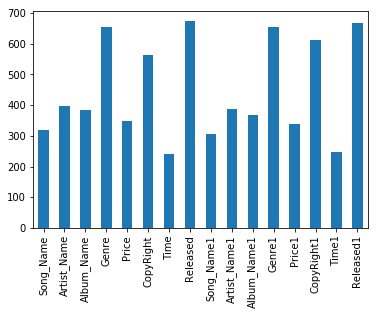

In [50]:
neg_ri_sums.plot.bar()

In [52]:
current_sample = 0
#each column of this matrix is related to a specific attribute
positives_ri_matrix = []
for batch in test_positive_classifier_inputs:
    for sample_index in range(len(batch)):
        print('Processing sample number {}'.format(current_sample))
        current_sample_ris = list(map(lambda att: find_smallest_variation_to_change(hybrid_model.classifier,
                                                                                    classifier_length=2400,
                                                                                    attribute_length=150,
                                                                                    input_matrix=batch,
                                                                                    vector_index=sample_index,
                                                                                    attributes=[attribute_duplicates.index(att)]
                                                                                    ,class_to_reach=0),attribute_duplicates))
        positives_ri_matrix.append(current_sample_ris)
        current_sample+=1

Processing sample number 0
Processing sample number 1
Processing sample number 2
Processing sample number 3
Processing sample number 4
Processing sample number 5
Processing sample number 6
Processing sample number 7
Processing sample number 8
Processing sample number 9
Processing sample number 10
Processing sample number 11
Processing sample number 12
Processing sample number 13
Processing sample number 14
Processing sample number 15
Processing sample number 16
Processing sample number 17
Processing sample number 18
Processing sample number 19
Processing sample number 20
Processing sample number 21
Processing sample number 22
Processing sample number 23
Processing sample number 24
Processing sample number 25
Processing sample number 26


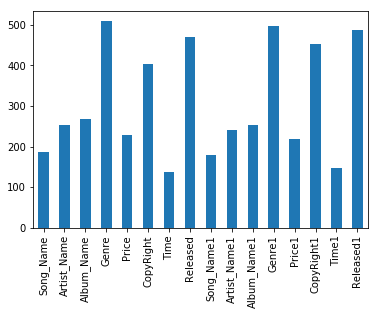

In [53]:
ri_norms_positives = []
for ri_list in positives_ri_matrix:
    ri_norms_positives.append(list(map(lambda x:torch.norm(x).data[0],ri_list)))
variation_df = pd.DataFrame(data= ri_norms_positives,columns=attribute_duplicates)
pos_ri_sums = variation_df.sum()
pos_ri_sums.plot.bar()

## Calculate ranking with couples of same attributes

In [6]:
hybrid_model = dm.MatchingModel(attr_summarizer='hybrid')
hybrid_model.load_state("../../models/itunesamazon_dupcolumns_hybrid.pth")
hybrid_model.cuda()

MatchingModel(
  (attr_summarizers): ModuleMap(
    (Song_Name): Hybrid(
      (word_contextualizer): RNN(
        (rnn_groups): ModuleList(
          (0): GRU(300, 150, batch_first=True, bidirectional=True)
        )
        (dropouts): ModuleList(
          (0): Dropout(p=0)
        )
        (bypass_networks): ModuleList(
          (0): None
        )
        (input_dropout): NoMeta(
          (module): Dropout(p=0)
        )
      )
      (word_comparator): Attention(
        (alignment_networks): ModuleList(
          (0): AlignmentNetwork(
            (transform): Transform(
              (transforms): ModuleList(
                (0): Linear(in_features=300, out_features=300, bias=True)
                (1): Linear(in_features=300, out_features=300, bias=True)
              )
              (bypass_networks): ModuleList(
                (0): Bypass(
                  (highway_gate): Linear(in_features=300, out_features=300, bias=True)
                )
                (1): Bypass(


In [11]:
attributes = ['Song_Name','Artist_Name','Album_Name','Genre','Price','CopyRight','Time','Released']
attribute_couples = []
for att in attributes:
    attribute_couples.append([att,att+"1"])

In [13]:
column_names = []
for att_set in attribute_couples:
    column_names.append(att_set[0][0:3]+'-'+att_set[1][0:3])

In [7]:
attribute_duplicates

['Song_Name',
 'Artist_Name',
 'Album_Name',
 'Genre',
 'Price',
 'CopyRight',
 'Time',
 'Released',
 'Song_Name1',
 'Artist_Name1',
 'Album_Name1',
 'Genre1',
 'Price1',
 'CopyRight1',
 'Time1',
 'Released1']

In [8]:
testneg_classifier_inputs,testneg_ids = return_layer_input('temp','test_negatives_dupcolumns',32,hybrid_model,
                                                                        hybrid_model.classifier,dataset2_name='valid_dupcolumns.csv')

In [9]:
testpos_classifier_inputs,testpos_ids = return_layer_input('temp/',
                                                                       'test_positives_dupcolumns',32,hybrid_model,
                                                                       hybrid_model.classifier,dataset2_name='valid_dupcolumns.csv')

In [10]:
test_negative_classifier_inputs = list(map(lambda x: x[0],testneg_classifier_inputs))
test_positive_classifier_inputs = list(map(lambda x: x[0],testpos_classifier_inputs))

In [26]:
from utilities_functions.ri_calculator import find_smallest_variation_to_change
current_sample = 0
#each column of this matrix is related to a specific attribute
negatives_ri_matrix = []
for batch in test_negative_classifier_inputs:
    for sample_index in range(len(batch)):
        print('Processing sample number {}'.format(current_sample))
        current_sample_ris = list(map(lambda att_couple: find_smallest_variation_to_change(hybrid_model.classifier,
                                                                                    classifier_length=2400,
                                                                                    attribute_length=150,
                                                                                    input_matrix=batch,
                                                                                    vector_index=sample_index,
                                                                                    attributes=[attribute_duplicates.index(attr)
                                                                                               for attr in att_couple]
                                                                                    ,class_to_reach=1),attribute_couples))
        negatives_ri_matrix.append(current_sample_ris)
        current_sample+=1

Processing sample number 0
Processing sample number 1
Processing sample number 2
Processing sample number 3
Processing sample number 4
Processing sample number 5
Processing sample number 6
Processing sample number 7
Processing sample number 8
Processing sample number 9
Processing sample number 10
Processing sample number 11
Processing sample number 12
Processing sample number 13
Processing sample number 14
Processing sample number 15
Processing sample number 16
Processing sample number 17
Processing sample number 18
Processing sample number 19
Processing sample number 20
Processing sample number 21
Processing sample number 22
Processing sample number 23
Processing sample number 24
Processing sample number 25
Processing sample number 26
Processing sample number 27
Processing sample number 28
Processing sample number 29
Processing sample number 30
Processing sample number 31
Processing sample number 32
Processing sample number 33
Processing sample number 34
Processing sample number 35
Pr

In [27]:
ri_norms_negative_samples = []
for ri_list in negatives_ri_matrix:
    ri_norms_negative_samples.append(list(map(lambda x:torch.norm(x).data[0],ri_list)))

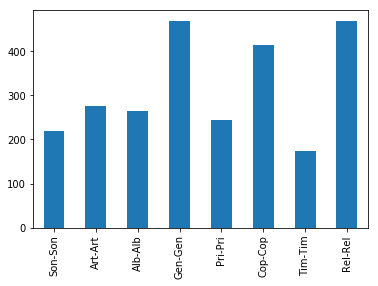

In [28]:
neg_variation_df = pd.DataFrame(data = ri_norms_negative_samples,columns = column_names)
sum_ri = neg_variation_df.sum()
plt = sum_ri.plot
plt.bar()

## Positives analysis

In [19]:
attribute_couples

[['Song_Name', 'Song_Name1'],
 ['Artist_Name', 'Artist_Name1'],
 ['Album_Name', 'Album_Name1'],
 ['Genre', 'Genre1'],
 ['Price', 'Price1'],
 ['CopyRight', 'CopyRight1'],
 ['Time', 'Time1'],
 ['Released', 'Released1']]

In [20]:
attribute_duplicates.index

['Song_Name',
 'Artist_Name',
 'Album_Name',
 'Genre',
 'Price',
 'CopyRight',
 'Time',
 'Released',
 'Song_Name1',
 'Artist_Name1',
 'Album_Name1',
 'Genre1',
 'Price1',
 'CopyRight1',
 'Time1',
 'Released1']

In [22]:
attribute_lenght= len(attributes)

current_sample = 0
#each column of this matrix is related to a specific attribute
positives_ri_matrix = []
for batch in test_positive_classifier_inputs:
    for sample_index in range(len(batch)):
        print('Processing sample {}'.format(current_sample))
        current_sample_ris = current_sample_ris = list(map(lambda att_couple: find_smallest_variation_to_change(hybrid_model.classifier,
                                                                                    classifier_length=2400,
                                                                                    attribute_length=150,
                                                                                    input_matrix=batch,
                                                                                    vector_index=sample_index,
                                                                                    attributes=[attribute_duplicates.index(attr)
                                                                                               for attr in att_couple]
                                                                                    ,class_to_reach=0),attribute_couples))
        positives_ri_matrix.append(current_sample_ris)
        current_sample+=1

Processing sample 0
Processing sample 1
Processing sample 2
Processing sample 3
Processing sample 4
Processing sample 5
Processing sample 6
Processing sample 7
Processing sample 8
Processing sample 9
Processing sample 10
Processing sample 11
Processing sample 12
Processing sample 13
Processing sample 14
Processing sample 15
Processing sample 16
Processing sample 17
Processing sample 18
Processing sample 19
Processing sample 20
Processing sample 21
Processing sample 22
Processing sample 23
Processing sample 24
Processing sample 25
Processing sample 26


In [23]:
ri_norms_positive_samples = []
for ri_list in positives_ri_matrix:
    ri_norms_positive_samples.append(list(map(lambda x:torch.norm(x).data[0],ri_list)))

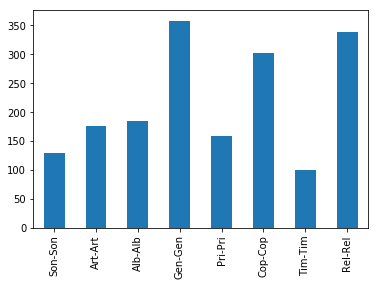

In [25]:
variation_pos_df = pd.DataFrame(data =ri_norms_positive_samples,columns = column_names)
ri_sum_pos = variation_pos_df.sum()
ri_sum_pos.plot.bar()